# Курсовой проект

**Материалы к проекту (файлы):** train.csv, test.csv

**Задание:** Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели предсказать цены для квартир из файла test.csv.

**Целевая переменная:** Price

**Метрика:** R2 - коэффициент детерминации (sklearn.metrics.r2_score)

## 0. Загрузка библиотек и дополнительные функции

In [1]:
import numpy as np
import pandas as pd

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# plt.style.use('fivethirtyeight')

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV

In [4]:
def data_dummies(*args):
    '''Функция для создания новой бинарной переменной из категориальной со значениями A и B'''
    for name in args:
        df[f'{name}_A(bin)'] = pd.get_dummies(df[name]).A

In [5]:
def price_hist(data):
    '''Функция для создания графика распределения целевой переменной'''
    fig, ax = plt.subplots(figsize=(10,6))
    ax.hist(data, bins=50)

    ax.set_xlabel('Цена квартиры', fontsize=10)
    ax.set_ylabel('Количество', fontsize=10)
    ax.set_title('Распределение стоимости квартир', fontsize=14)
    
    plt.show()

In [295]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2_score(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2_score(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(10,8))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Прогнозируемые значения')
    plt.ylabel('Истиные значения')
    plt.title('Прогнозирование обучающей выборки')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Прогнозируемые значения')
    plt.ylabel('Истиные значения')
    plt.title('Прогнозирование тестовой выборки')

    plt.show()

## 1. Загрузка данных

In [321]:
df = pd.read_csv('train.csv')

In [322]:
df_test = pd.read_csv('test.csv')

In [323]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


### Описание данных

- Id - идентификационный номер квартиры
- DistrictId - идентификационный номер района
- Rooms - количество комнат
- Square - площадь
- LifeSquare - жилая площадь
- KitchenSquare - площадь кухни
- Floor - этаж
- HouseFloor - количество этажей в доме
- HouseYear - год постройки дома
- Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
- Social_1, Social_2, Social_3 - социальные показатели местности
- Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
- Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
- Price - цена квартиры

## 2. EDA и очистка данных

In [324]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [325]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Изменяем тип переменной 'DistrictID'

In [326]:
df['DistrictId'] = df['DistrictId'].astype(str)

### Распределение целевой переменной

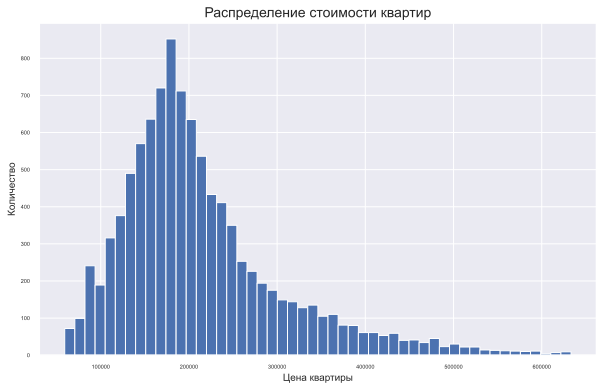

In [327]:
price_hist(df['Price'])

### Разбиваем переменные на бинарные

In [328]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [329]:
df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [330]:
df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [331]:
df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [332]:
pd.get_dummies(df['Ecology_2'])

,A,B
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
9995,0,1
9996,0,1
9997,0,1
9998,0,1


In [333]:
data_dummies('Ecology_2', 'Ecology_3', 'Shops_2')

In [334]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_A(bin),Ecology_3_A(bin),Shops_2_A(bin)
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,7976,5,NaN,0,11,B,184966.930730,0,0,0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,10309,1,240.0,1,16,B,300009.450063,0,0,0
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,7759,0,229.0,1,3,B,220925.908524,0,0,0
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,5735,3,1084.0,0,5,B,175616.227217,0,0,0
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,5776,1,2078.0,2,4,B,150226.531644,0,0,0


In [335]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                10000 non-null  int64  
 1   DistrictId        10000 non-null  object 
 2   Rooms             10000 non-null  float64
 3   Square            10000 non-null  float64
 4   LifeSquare        7887 non-null   float64
 5   KitchenSquare     10000 non-null  float64
 6   Floor             10000 non-null  int64  
 7   HouseFloor        10000 non-null  float64
 8   HouseYear         10000 non-null  int64  
 9   Ecology_1         10000 non-null  float64
 10  Ecology_2         10000 non-null  object 
 11  Ecology_3         10000 non-null  object 
 12  Social_1          10000 non-null  int64  
 13  Social_2          10000 non-null  int64  
 14  Social_3          10000 non-null  int64  
 15  Healthcare_1      5202 non-null   float64
 16  Helthcare_2       10000 non-null  int64  

### Убираем выбросы

Убираем выбросы и нулевые значения у 'Rooms', создаем дополнительный столбец 'Rooms_outlier'

In [336]:
df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

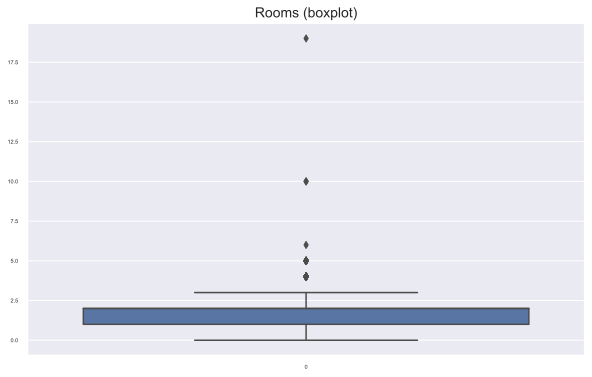

In [337]:
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(df['Rooms'])
ax.set_title('Rooms (boxplot)', fontsize=14)
plt.show()

In [338]:
df[df['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_A(bin),Ecology_3_A(bin),Shops_2_A(bin)
1397,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,...,3097,0,NaN,0,0,B,268394.744389,0,0,0
1981,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,...,1892,0,NaN,0,1,B,302211.260887,0,0,0
2269,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,...,1892,0,NaN,0,1,B,98129.976788,0,0,0
3911,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,...,6207,1,1183.0,1,0,B,217009.338463,0,0,0
4366,456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,...,1564,0,540.0,0,0,B,212864.799112,0,0,0
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,...,469,0,NaN,0,0,B,126596.941798,0,0,0
6149,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,...,8429,3,NaN,3,9,B,158998.110646,0,0,0
8834,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,...,1892,0,NaN,0,1,B,219281.918007,0,0,0


In [339]:
df['Rooms_outlier'] = 0
df.loc[df['Rooms'] == 0, 'Rooms_outlier'] = 1

In [340]:
df.loc[df['Rooms'] == 0, 'Rooms'] = 1

In [341]:
df[df['Rooms'] >= 10]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_A(bin),Ecology_3_A(bin),Shops_2_A(bin),Rooms_outlier
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,...,2,NaN,5,15,B,317265.323792,0,0,0,0
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,...,0,NaN,0,1,B,78364.616704,0,0,0,0
8849,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,...,1,30.0,2,4,B,172329.270863,0,0,0,0


In [342]:
df.loc[df['Rooms'] >= 10, 'Rooms_outlier'] = 1

In [343]:
df.loc[df['Rooms'] >= 10, 'Rooms'] = df['Rooms'].median()

In [344]:
df['Rooms'].value_counts()

2.0    3883
1.0    3713
3.0    2235
4.0     150
5.0      18
6.0       1
Name: Rooms, dtype: int64

Убираем выбросы и нулевые значения у 'HouseFloor'

In [345]:
df[df['HouseFloor'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_A(bin),Ecology_3_A(bin),Shops_2_A(bin),Rooms_outlier
7,11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,...,3,NaN,0,2,B,221244.156664,0,0,0,0
23,6641,54,3.0,118.907612,NaN,0.0,2,0.0,1977,0.006076,...,0,645.0,6,6,B,571069.052600,0,0,0,0
26,4378,27,3.0,106.958871,0.641822,0.0,17,0.0,2018,0.072158,...,1,NaN,0,0,A,337299.867936,0,0,1,0
39,9371,23,2.0,60.503248,NaN,0.0,16,0.0,1977,0.034656,...,0,NaN,0,0,B,229778.057902,0,0,0,0
44,10521,38,3.0,104.211396,106.340403,0.0,20,0.0,2017,0.060753,...,2,520.0,0,7,B,435462.048070,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9707,12302,30,1.0,46.072913,48.307844,0.0,4,0.0,1977,0.000078,...,141,1046.0,3,23,B,161403.094034,0,0,0,0
9769,9384,59,3.0,98.607328,NaN,0.0,14,0.0,1977,0.019509,...,11,176.0,5,5,B,492700.257473,0,0,0,0
9878,11441,62,2.0,71.985335,72.453232,0.0,5,0.0,1977,0.072158,...,1,NaN,0,0,A,158841.624543,0,0,1,0
9908,3171,62,1.0,35.873961,NaN,0.0,25,0.0,1977,0.072158,...,1,NaN,0,0,A,134379.130962,0,0,1,0


In [346]:
df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = df.loc[df['HouseFloor'] == 0, 'Floor']

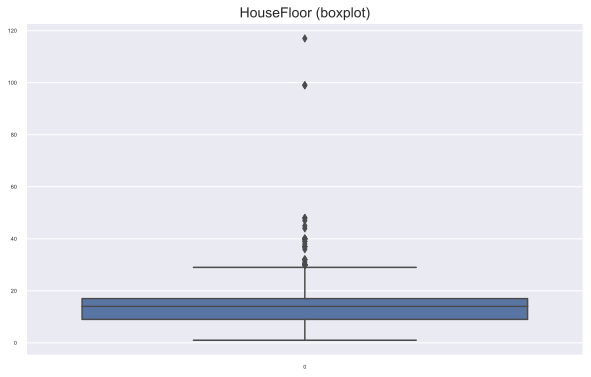

In [347]:
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(df['HouseFloor'])
ax.set_title('HouseFloor (boxplot)', fontsize=14)
plt.show()

In [348]:
df[df['HouseFloor'] > 50]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_A(bin),Ecology_3_A(bin),Shops_2_A(bin),Rooms_outlier
6131,10806,5,1.0,51.944587,48.709601,1.0,6,99.0,1977,0.150818,...,4,2643.0,4,5,B,296127.115515,0,0,0,0
8599,9300,74,2.0,71.747869,74.579809,9.0,5,99.0,1977,0.075779,...,3,NaN,0,2,B,243329.912579,0,0,0,0
8854,78,30,2.0,65.773749,66.811789,1.0,8,117.0,1977,0.000078,...,141,1046.0,3,23,B,207248.370520,0,0,0,0


In [349]:
df[df['HouseYear'] == 1977]['HouseFloor'].median()

17.0

In [350]:
df.loc[df['HouseFloor'] > 50, 'HouseFloor'] = df['HouseFloor'].median()

<AxesSubplot: >

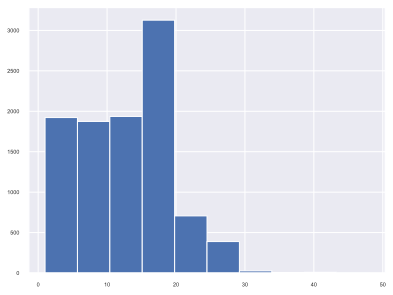

In [351]:
df['HouseFloor'].hist()

Убираем выбросы 'HouseYear' (года, больше 2022)

In [352]:
df[df['HouseYear'] > 2022]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_A(bin),Ecology_3_A(bin),Shops_2_A(bin),Rooms_outlier
1497,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,...,10,262.0,3,6,B,254084.534396,0,0,0,0
4189,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,...,16,2857.0,5,8,B,243028.603096,0,0,0,0


In [353]:
df['HouseYear'].median()

1977.0

In [354]:
df.loc[df['HouseYear'] > 2022, 'HouseYear'] = df['HouseYear'].median()

<AxesSubplot: >

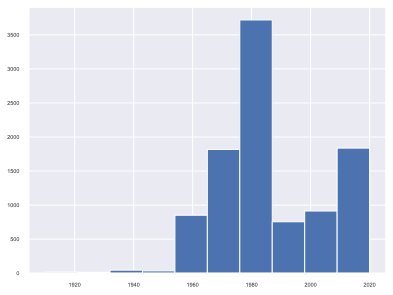

In [355]:
df['HouseYear'].hist()

Убираем выбросы у 'KitchenSquare' и ставим минимальную площадь кухни - 4 м2

In [356]:
df.loc[df['KitchenSquare'] > df['KitchenSquare'].quantile(0.99), 'KitchenSquare'] = df['KitchenSquare'].quantile(0.99)

In [357]:
df.loc[df['KitchenSquare'] < 4, 'KitchenSquare'] = 4

<AxesSubplot: >

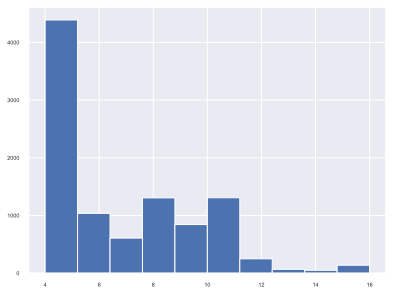

In [358]:
df['KitchenSquare'].hist()

### Обработка пропусков

In [359]:
df.isna().sum()

Id                     0
DistrictId             0
Rooms                  0
Square                 0
LifeSquare          2113
KitchenSquare          0
Floor                  0
HouseFloor             0
HouseYear              0
Ecology_1              0
Ecology_2              0
Ecology_3              0
Social_1               0
Social_2               0
Social_3               0
Healthcare_1        4798
Helthcare_2            0
Shops_1                0
Shops_2                0
Price                  0
Ecology_2_A(bin)       0
Ecology_3_A(bin)       0
Shops_2_A(bin)         0
Rooms_outlier          0
dtype: int64

Убираем пропуски 'LifeSquare'

In [360]:
df['LifeSquare'].median()

32.78126019215574

In [361]:
df['LifeSquare_outlier'] = 0
df.loc[df['LifeSquare'].isna(), 'LifeSquare_outlier'] = 1
df[df['LifeSquare'].isna()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_A(bin),Ecology_3_A(bin),Shops_2_A(bin),Rooms_outlier,LifeSquare_outlier
7,11993,74,2.0,80.312926,NaN,4.0,14,14.0,1977,0.075779,...,NaN,0,2,B,221244.156664,0,0,0,0,1
8,5172,1,2.0,64.511437,NaN,4.0,9,17.0,1977,0.007122,...,NaN,0,1,B,229102.795999,0,0,0,0,1
21,11935,27,2.0,64.711835,NaN,4.0,15,1.0,1977,0.211401,...,NaN,0,1,B,127200.026511,0,0,0,0,1
23,6641,54,3.0,118.907612,NaN,4.0,2,2.0,1977,0.006076,...,645.0,6,6,B,571069.052600,0,0,0,0,1
25,5073,74,2.0,82.667915,NaN,4.0,16,17.0,1977,0.075779,...,NaN,0,2,B,244145.827069,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,16159,27,1.0,38.968338,NaN,4.0,10,1.0,1977,0.211401,...,NaN,0,1,B,95529.569405,0,0,0,0,1
9986,2996,1,2.0,64.994245,NaN,4.0,9,22.0,1977,0.007122,...,NaN,0,1,B,200332.511658,0,0,0,0,1
9987,15623,23,2.0,55.620092,NaN,4.0,2,4.0,1977,0.034656,...,NaN,0,0,B,115797.553006,0,0,0,0,1
9994,4158,23,2.0,64.864198,NaN,4.0,17,17.0,1977,0.075779,...,NaN,0,2,B,171323.515653,0,0,0,0,1


In [362]:
df.loc[df['LifeSquare'].isna(), 'LifeSquare'] = df.loc[df['LifeSquare'].isna(), 'Square'] - \
                                                df.loc[df['LifeSquare'].isna(), 'KitchenSquare'] - 3
df.loc[[7, 8, 21, 23, 25]]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_A(bin),Ecology_3_A(bin),Shops_2_A(bin),Rooms_outlier,LifeSquare_outlier
7,11993,74,2.0,80.312926,73.312926,4.0,14,14.0,1977,0.075779,...,NaN,0,2,B,221244.156664,0,0,0,0,1
8,5172,1,2.0,64.511437,57.511437,4.0,9,17.0,1977,0.007122,...,NaN,0,1,B,229102.795999,0,0,0,0,1
21,11935,27,2.0,64.711835,57.711835,4.0,15,1.0,1977,0.211401,...,NaN,0,1,B,127200.026511,0,0,0,0,1
23,6641,54,3.0,118.907612,111.907612,4.0,2,2.0,1977,0.006076,...,645.0,6,6,B,571069.052600,0,0,0,0,1
25,5073,74,2.0,82.667915,75.667915,4.0,16,17.0,1977,0.075779,...,NaN,0,2,B,244145.827069,0,0,0,0,1


In [363]:
df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare               0
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Ecology_2_A(bin)         0
Ecology_3_A(bin)         0
Shops_2_A(bin)           0
Rooms_outlier            0
LifeSquare_outlier       0
dtype: int64

Убираем пропуски 'Healthcare_1'

In [364]:
df['Healthcare_1'].median()

900.0

In [365]:
df['Healthcare_1_outlier'] = 0
df.loc[df['Healthcare_1'].isna(), 'Healthcare_1_outlier'] = 1
df[df['Healthcare_1'].isna()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_A(bin),Ecology_3_A(bin),Shops_2_A(bin),Rooms_outlier,LifeSquare_outlier,Healthcare_1_outlier
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,0,11,B,184966.930730,0,0,0,0,0,1
6,14549,154,2.0,62.254114,37.160377,7.0,3,5.0,1960,0.460556,...,1,5,B,296021.204377,0,0,0,0,0,1
7,11993,74,2.0,80.312926,73.312926,4.0,14,14.0,1977,0.075779,...,0,2,B,221244.156664,0,0,0,0,1,1
8,5172,1,2.0,64.511437,57.511437,4.0,9,17.0,1977,0.007122,...,0,1,B,229102.795999,0,0,0,0,1,1
9,8649,23,1.0,46.461409,18.915552,8.0,13,17.0,2014,0.075779,...,0,2,B,95380.220993,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9992,14333,150,3.0,78.249637,49.385096,10.0,5,16.0,1976,0.300323,...,1,9,B,342418.758888,0,0,0,0,0,1
9993,48,13,3.0,80.631333,48.899083,10.0,11,14.0,1999,0.090799,...,5,15,B,350684.628560,0,0,0,0,0,1
9994,4158,23,2.0,64.864198,57.864198,4.0,17,17.0,1977,0.075779,...,0,2,B,171323.515653,0,0,0,0,1,1
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,...,0,5,A,189050.289571,0,0,1,0,0,1


In [366]:
df['Healthcare_1'] = df['Healthcare_1'].fillna(df['Healthcare_1'].median())

In [367]:
df.isna().sum()

Id                      0
DistrictId              0
Rooms                   0
Square                  0
LifeSquare              0
KitchenSquare           0
Floor                   0
HouseFloor              0
HouseYear               0
Ecology_1               0
Ecology_2               0
Ecology_3               0
Social_1                0
Social_2                0
Social_3                0
Healthcare_1            0
Helthcare_2             0
Shops_1                 0
Shops_2                 0
Price                   0
Ecology_2_A(bin)        0
Ecology_3_A(bin)        0
Shops_2_A(bin)          0
Rooms_outlier           0
LifeSquare_outlier      0
Healthcare_1_outlier    0
dtype: int64

### Добавляем новые признаки

Создаем признак 'District_med_price' (средняя стоимость квартир данного района)

In [368]:
df_dist = df.groupby('DistrictId')['Price'].median()
df_dist

DistrictId
0      165963.054142
1      183663.443595
10     217749.656911
100    234032.836228
101    184276.502773
           ...      
95     293249.106761
96     200440.676982
97     193772.806849
98     191914.221629
99     178829.166450
Name: Price, Length: 205, dtype: float64

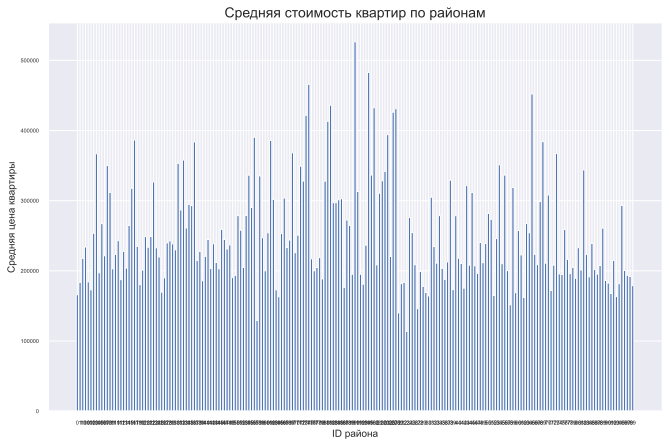

In [369]:
fig, ax = plt.subplots(figsize=(11,7))
ax.bar(df_dist.index, df_dist)

ax.set_xlabel('ID района', fontsize=10)
ax.set_ylabel('Средняя цена квартиры', fontsize=10)
ax.set_title('Средняя стоимость квартир по районам', fontsize=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

In [370]:
df['District_med_price'] = df['DistrictId'].apply(lambda x: df_dist.loc[x])
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,Ecology_2_A(bin),Ecology_3_A(bin),Shops_2_A(bin),Rooms_outlier,LifeSquare_outlier,Healthcare_1_outlier,District_med_price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,11,B,184966.930730,0,0,0,0,0,1,203602.408898
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,16,B,300009.450063,0,0,0,0,0,0,210694.850106
2,4765,53,2.0,44.947953,29.197612,4.0,8,12.0,1968,0.049637,...,3,B,220925.908524,0,0,0,0,0,0,245978.794474
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,5,B,175616.227217,0,0,0,0,0,0,151557.904767
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,4,B,150226.531644,0,0,0,0,0,0,178829.166450


Создаем признак 'Floor_med_price' (средняя стоимость квартир на этаже)

In [371]:
df_floor = df.groupby('Floor')['Price'].median()
df_floor

Floor
1     169061.669560
2     183601.304365
3     180522.397155
4     189341.908219
5     190227.249964
6     189412.316654
7     197245.267664
8     198819.511617
9     195029.868979
10    196250.492789
11    195507.880289
12    190217.223931
13    199259.147396
14    199486.489638
15    203190.650926
16    191316.391017
17    199517.589213
18    192358.950694
19    198981.146135
20    229457.910127
21    215912.557642
22    279761.392940
23    260960.450895
24    245736.934369
25    217451.998567
26    276618.475193
27    211498.637627
28    333862.631152
31    117647.461002
32    245640.188762
33    389554.063540
37    269113.584248
42    411691.504766
Name: Price, dtype: float64

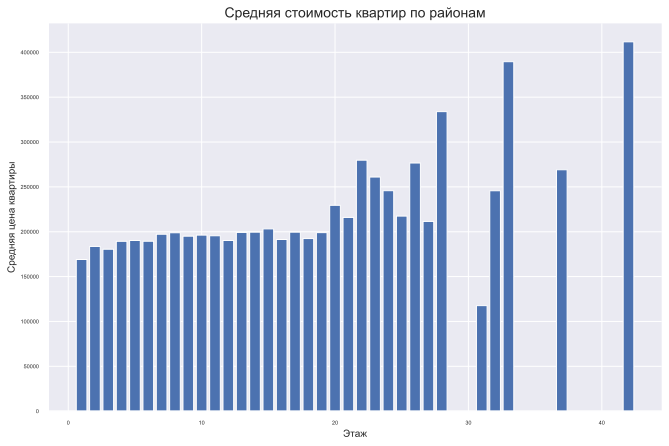

In [372]:
fig, ax = plt.subplots(figsize=(11,7))
ax.bar(df_floor.index, df_floor)

ax.set_xlabel('Этаж', fontsize=10)
ax.set_ylabel('Средняя цена квартиры', fontsize=10)
ax.set_title('Средняя стоимость квартир по районам', fontsize=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

In [373]:
df['Floor_med_price'] = df['Floor'].apply(lambda x: df_floor.loc[x])
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Ecology_2_A(bin),Ecology_3_A(bin),Shops_2_A(bin),Rooms_outlier,LifeSquare_outlier,Healthcare_1_outlier,District_med_price,Floor_med_price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,B,184966.930730,0,0,0,0,0,1,203602.408898,197245.267664
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,B,300009.450063,0,0,0,0,0,0,210694.850106,197245.267664
2,4765,53,2.0,44.947953,29.197612,4.0,8,12.0,1968,0.049637,...,B,220925.908524,0,0,0,0,0,0,245978.794474,198819.511617
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,B,175616.227217,0,0,0,0,0,0,151557.904767,198819.511617
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,B,150226.531644,0,0,0,0,0,0,178829.166450,195507.880289


C:\Users\Anna2\AppData\Local\Temp\ipykernel_16992\2318983501.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, linewidths=.5, cmap='GnBu')


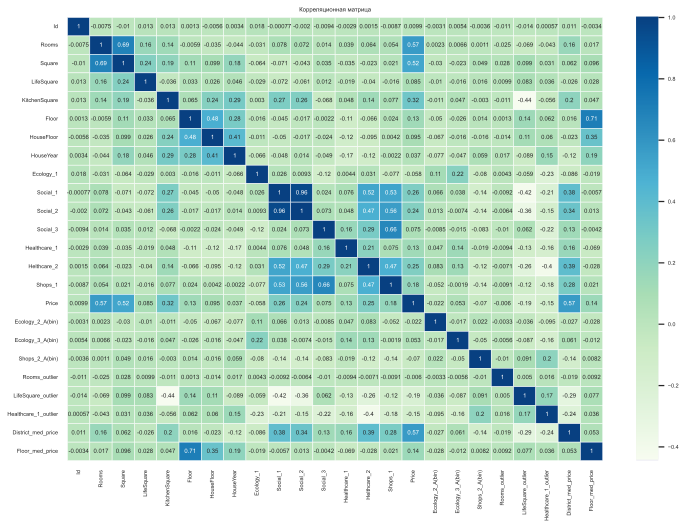

In [374]:
plt.figure(figsize = (12,8))

sns.set(font_scale=0.5)
sns.heatmap(df.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Корреляционная матрица')
plt.show()

## 3. Построение модели

### Отбираем признаки для модели

In [382]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1','Social_1', 
                 'Social_3', 'Helthcare_2', 'Shops_1', 'Ecology_2_A(bin)', 'Ecology_3_A(bin)', 'Shops_2_A(bin)', 
                 'LifeSquare_outlier', 'Healthcare_1_outlier', 'Rooms_outlier', 'District_med_price', 'Floor_med_price']
target_name = 'Price'

In [383]:
X = df[feature_names]
y = df[target_name]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

### Построение модели RandomForestRegressor

In [384]:
model = RandomForestRegressor(n_estimators=1000, max_depth=15, random_state=42)

In [385]:
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, n_estimators=1000, random_state=42)

In [386]:
y_pred_RFR = model.predict(X_valid)

In [387]:
r2_score(y_valid, y_pred_RFR)

0.7273253333986118

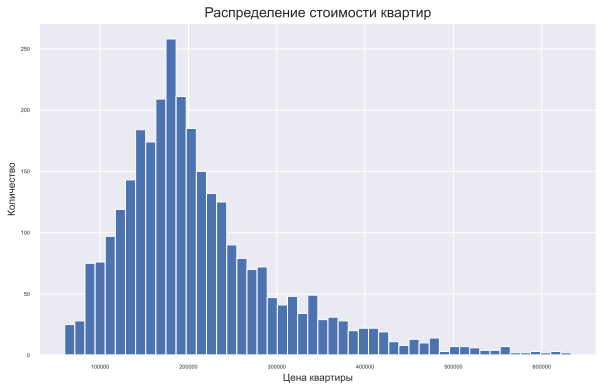

In [388]:
price_hist(y_valid)

Train R2:	0.954
Test R2:	0.727


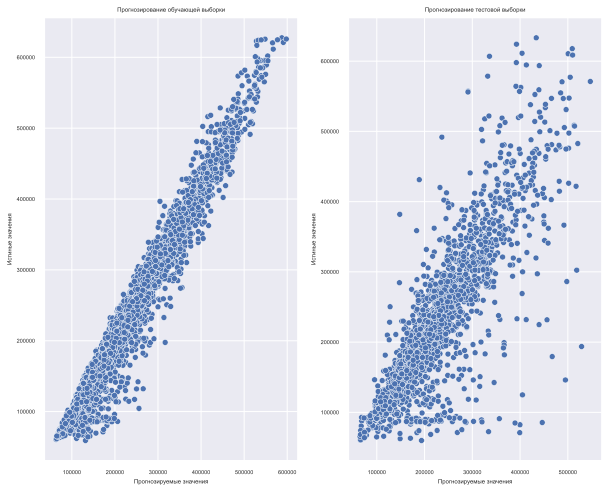

In [389]:
y_train_preds = model.predict(X_train)
y_valid_preds = model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

### Кросс-валидация и важность признаков

In [390]:
cv_score = cross_val_score(model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.72455697, 0.72103637, 0.75008789])

In [391]:
cv_score.mean()

0.7318937433009131

In [392]:
feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.420456
18,District_med_price,0.313881
8,Social_1,0.034285
9,Social_3,0.033721
2,LifeSquare,0.031962
0,Rooms,0.029331
6,HouseYear,0.027260
3,KitchenSquare,0.018732
7,Ecology_1,0.018488
5,HouseFloor,0.017169


## 4. Предсказание тестовых данных

Создаем класс для обработки тестовых данных

In [393]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.healthcare_median = None
        self.rooms_median = None
        self.housefloor_median = None
        self.houseyear_median = None
        self.kitchen_quantile = None

        
    def fit(self, df):
        """Сохранение статистик"""
        self.healthcare_median = df['Healthcare_1'].median()
        self.rooms_median = df['Rooms'].median()
        self.housefloor_median = df['HouseFloor'].median()
        self.houseyear_median = df['HouseYear'].median()
        self.kitchen_quantile = df['KitchenSquare'].quantile(0.99)
    
    
    def transform(self, df):
        """Трансформация данных"""
        
        # Разбиваем на бинарные переменные
        def dummies(*args):
            for name in args:
                df[f'{name}_A(bin)'] = pd.get_dummies(df[name]).A

        dummies('Ecology_2', 'Ecology_3', 'Shops_2')

        # Выбросы
        # Rooms
        df['Rooms_outlier'] = 0
        df.loc[(df['Rooms'] == 0) | (df['Rooms'] >= 10), 'Rooms_outlier'] = 1
        df.loc[df['Rooms'] == 0, 'Rooms'] = 1
        df.loc[df['Rooms'] >= 10, 'Rooms'] = self.rooms_median
        
        # HouseFloor
        df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = df.loc[df['HouseFloor'] == 0, 'Floor']
        df.loc[df['HouseFloor'] > 50, 'HouseFloor'] = self.housefloor_median
        
        # HouseYear
        df.loc[df['HouseYear'] > 2022, 'HouseYear'] = self.houseyear_median
        
        # KitchenSquare
        df.loc[df['KitchenSquare'] > self.kitchen_quantile, 'KitchenSquare'] = self.kitchen_quantile
        df.loc[df['KitchenSquare'] < 4, 'KitchenSquare'] = 4

                      
        # Пропуски
        # LifeSquare
        df['LifeSquare_outlier'] = 0
        df.loc[df['LifeSquare'].isna(), 'LifeSquare_outlier'] = 1
        df.loc[df['LifeSquare'].isna(), 'LifeSquare'] = df.loc[df['LifeSquare'].isna(), 'Square'] - \
                                                        df.loc[df['LifeSquare'].isna(), 'KitchenSquare'] - 3
        
        # Healthcare_1
        df['Healthcare_1_outlier'] = 0
        df.loc[df['Healthcare_1'].isna(), 'Healthcare_1_outlier'] = 1
        df['Healthcare_1'] = df['Healthcare_1'].fillna(self.healthcare_median)
 
        
        return df
     

In [394]:
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [395]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [396]:
preprocessor = DataPipeline()
preprocessor.fit(df)

X_test = preprocessor.transform(df_test)
X_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_A(bin),Ecology_3_A(bin),Shops_2_A(bin),Rooms_outlier,LifeSquare_outlier,Healthcare_1_outlier
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,900.0,0,0,B,0,0,0,0,0,1
1,15856,74,2.0,69.263183,62.263183,4.0,6,1.0,1977,0.075779,...,900.0,0,2,B,0,0,0,0,1,1
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,...,4702.0,5,5,B,0,0,0,0,0,0
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,900.0,3,3,B,0,0,0,0,0,1
4,14275,27,1.0,47.527111,43.387569,4.0,17,17.0,2017,0.072158,...,900.0,0,0,A,0,0,1,0,0,1


Добавляем новые признаки

In [397]:
X_test['District_med_price'] = X_test['DistrictId'].apply(lambda x: df_dist.loc[x] if x in df_dist.index else df_dist.median())
X_test['Floor_med_price'] = X_test['Floor'].apply(lambda x: df_floor.loc[x] if x in df_floor.index else df_floor.median())

In [398]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Id                    5000 non-null   int64  
 1   DistrictId            5000 non-null   int64  
 2   Rooms                 5000 non-null   float64
 3   Square                5000 non-null   float64
 4   LifeSquare            5000 non-null   float64
 5   KitchenSquare         5000 non-null   float64
 6   Floor                 5000 non-null   int64  
 7   HouseFloor            5000 non-null   float64
 8   HouseYear             5000 non-null   int64  
 9   Ecology_1             5000 non-null   float64
 10  Ecology_2             5000 non-null   object 
 11  Ecology_3             5000 non-null   object 
 12  Social_1              5000 non-null   int64  
 13  Social_2              5000 non-null   int64  
 14  Social_3              5000 non-null   int64  
 15  Healthcare_1         

In [399]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1','Social_1', 
                 'Social_3', 'Helthcare_2', 'Shops_1', 'Ecology_2_A(bin)', 'Ecology_3_A(bin)', 'Shops_2_A(bin)', 
                 'LifeSquare_outlier', 'Healthcare_1_outlier', 'Rooms_outlier', 'District_med_price', 'Floor_med_price']

In [400]:
X_test = X_test[feature_names]
X_test

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_3,Helthcare_2,Shops_1,Ecology_2_A(bin),Ecology_3_A(bin),Shops_2_A(bin),LifeSquare_outlier,Healthcare_1_outlier,Rooms_outlier,District_med_price,Floor_med_price
0,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,11,1,0,0,0,0,0,0,1,0,233005.925999,189412.316654
1,2.0,69.263183,62.263183,4.0,6,1.0,1977,0.075779,6,3,0,2,0,0,0,1,1,0,233005.925999,189412.316654
2,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,30,87,5,5,0,0,0,0,0,0,233005.925999,183601.304365
3,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,23,3,3,3,0,0,0,0,1,0,233005.925999,279761.392940
4,1.0,47.527111,43.387569,4.0,17,17.0,2017,0.072158,2,1,0,0,0,0,1,0,1,0,233005.925999,199517.589213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,36,0,1,1,0,0,0,0,1,0,233005.925999,190227.249964
4996,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,1,0,0,1,0,0,0,0,1,0,233005.925999,190217.223931
4997,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,74,2,5,15,0,0,0,0,1,0,233005.925999,260960.450895
4998,2.0,81.305222,74.305222,4.0,4,4.0,1977,0.072158,2,1,0,0,0,0,1,1,1,0,233005.925999,189341.908219


In [401]:
y_pred2_RFR = model.predict(X_test)

In [402]:
y_pred2_RFR

array([218714.11365181, 242604.2754521 , 170426.45774219, ...,
       310958.67553752, 272194.22795272, 293655.5817539 ])

In [411]:
df_test['Price'] = y_pred2_RFR
df_test

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Ecology_2_A(bin),Ecology_3_A(bin),Shops_2_A(bin),Rooms_outlier,LifeSquare_outlier,Healthcare_1_outlier,District_med_price,Floor_med_price,Price
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,B,0,0,0,0,0,1,233005.925999,189412.316654,218714.113652
1,15856,74,2.0,69.263183,62.263183,4.0,6,1.0,1977,0.075779,...,B,0,0,0,0,1,1,233005.925999,189412.316654,242604.275452
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,...,B,0,0,0,0,0,0,233005.925999,183601.304365,170426.457742
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,B,0,0,0,0,0,1,233005.925999,279761.392940,340592.846692
4,14275,27,1.0,47.527111,43.387569,4.0,17,17.0,2017,0.072158,...,A,0,0,1,0,0,1,233005.925999,199517.589213,192371.627631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,...,B,0,0,0,0,0,1,233005.925999,190227.249964,263514.881466
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,...,B,0,0,0,0,0,1,233005.925999,190217.223931,158354.515013
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,...,B,0,0,0,0,0,1,233005.925999,260960.450895,310958.675538
4998,4780,62,2.0,81.305222,74.305222,4.0,4,4.0,1977,0.072158,...,A,0,0,1,0,1,1,233005.925999,189341.908219,272194.227953


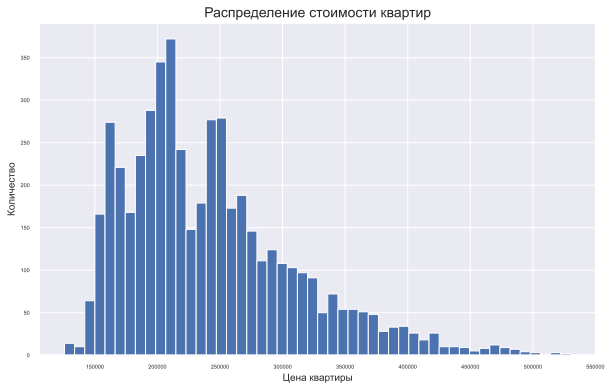

In [412]:
price_hist(df_test['Price'])

In [413]:
df_test.to_csv('predictions.csv', columns=['Id', 'Price'], index=False, encoding='utf-8')